In [1]:
import os
import sys
'''
MAIN_DIR = os.path.abspath(os.path.join(os.path.dirname(__file__), '..'))
sys.path.insert(0, MAIN_DIR)
os.chdir(MAIN_DIR)
'''

import gradio as gr
import numpy as np
import torch
import random

from annotator.util import resize_image, HWC3
from annotator.canny import CannyDetector
from diffusers.models.unet_2d_condition import UNet2DConditionModel
from diffusers.pipelines import DiffusionPipeline
from diffusers.schedulers import DPMSolverMultistepScheduler
#from models import ControlLoRA, ControlLoRACrossAttnProcessor

apply_canny = CannyDetector()

device = 'cuda' if torch.cuda.is_available() else 'cpu'



In [2]:

from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    DDPMScheduler,
    StableDiffusionControlNetPipeline,
    UNet2DConditionModel,
    UniPCMultistepScheduler,
)
import torch
from diffusers.utils import load_image

controlnet_model_name_or_path = "svjack/ControlNet-Canny-Zh"
controlnet = ControlNetModel.from_pretrained(controlnet_model_name_or_path)

base_model_path = "IDEA-CCNL/Taiyi-Stable-Diffusion-1B-Chinese-v0.1"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    base_model_path, controlnet=controlnet,
    #torch_dtype=torch.float16
)

# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
#pipe.enable_model_cpu_offload()
if device == "cuda":
    pipe = pipe.to("cuda")


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
unet/diffusion_pytorch_model.safetensors not found
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/environment/miniconda3/lib/python3.7/site-packages/transformers/models/clip/feature_extraction_clip.py:31: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transf

In [3]:
!ls

annotator  Protector_Cromwell_style.png  requirements.txt
app.py	   README.md			 Untitled.ipynb


In [4]:
from PIL import Image

In [5]:
!ls

annotator  Protector_Cromwell_style.png  requirements.txt
app.py	   README.md			 Untitled.ipynb


In [15]:
input_image = np.asarray(Image.open("Protector_Cromwell_style.png"))
image_resolution = 512
low_threshold = 0
high_threshold = 256
img = resize_image(HWC3(input_image), image_resolution)
H, W, C = img.shape

detected_map = apply_canny(img, low_threshold, high_threshold)
detected_map = HWC3(detected_map)

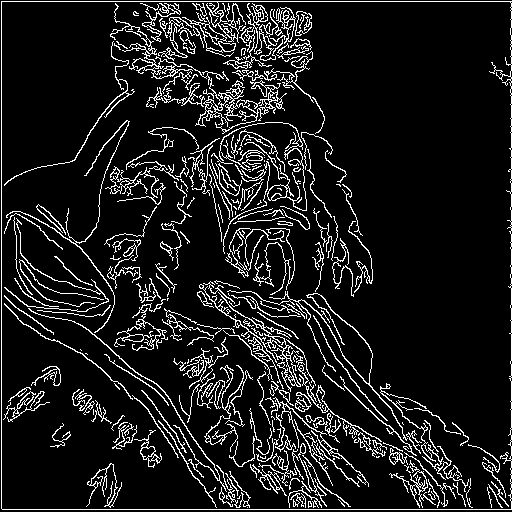

In [17]:
Image.fromarray(detected_map)

In [3]:
def process(input_image, prompt, a_prompt, n_prompt, num_samples, image_resolution, sample_steps, scale, seed, eta, low_threshold, high_threshold):
    from PIL import Image
    with torch.no_grad():
        img = resize_image(HWC3(input_image), image_resolution)
        H, W, C = img.shape

        detected_map = apply_canny(img, low_threshold, high_threshold)
        detected_map = HWC3(detected_map)
        '''
        print(type(detected_map))
        return [detected_map]

        control = torch.from_numpy(detected_map[...,::-1].copy().transpose([2,0,1])).float().to(device)[None] / 127.5 - 1
        _ = control_lora(control).control_states

        if seed == -1:
            seed = random.randint(0, 65535)
        '''
        if seed == -1:
            seed = random.randint(0, 65535)
        control_image = Image.fromarray(detected_map)

        # run inference
        generator = torch.Generator(device=device).manual_seed(seed)
        images = []
        for i in range(num_samples):
            '''
            _ = control_lora(control).control_states
            image = pipeline(
                prompt + ', ' + a_prompt, negative_prompt=n_prompt,
                num_inference_steps=sample_steps, guidance_scale=scale, eta=eta,
                generator=generator, height=H, width=W).images[0]
            '''
            image = pipe(
                prompt + ', ' + a_prompt, negative_prompt=n_prompt,
                num_inference_steps=sample_steps, guidance_scale=scale, eta=eta,
                image = control_image,
                generator=generator, height=H, width=W).images[0]
            images.append(np.asarray(image))

        results = images
    return [255 - detected_map] + results

In [9]:
results = process(
    np.asarray(Image.open("Protector_Cromwell_style.png")),
    "表情俏皮的小丑",
    "详细的模拟混合媒体拼贴画，帆布质地的当代艺术风格，朋克艺术，逼真主义，感性的身体，表现主义，极简主义。杰作，完美的组成，逼真的美丽的脸，壮观的质量，复杂的石油细节，生动的碎玻璃，撕裂的纸张，杂志页面高对比度，8k，高清",
    "低质量，模糊，混乱",
    3,
    512,
    70,
    9.0,
    10,
    0.0,
    100, 200
)

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

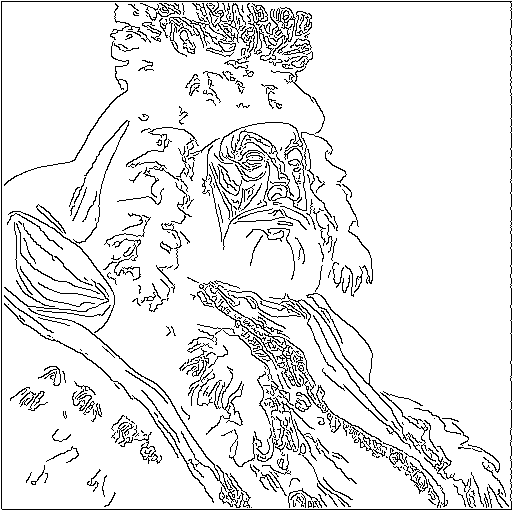

In [10]:
Image.fromarray(results[0])

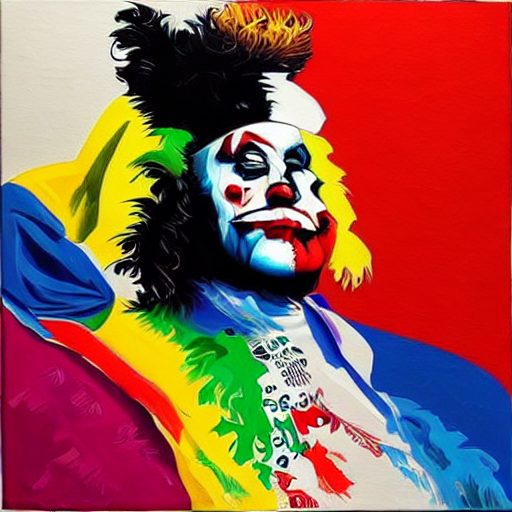

In [11]:
Image.fromarray(results[1])

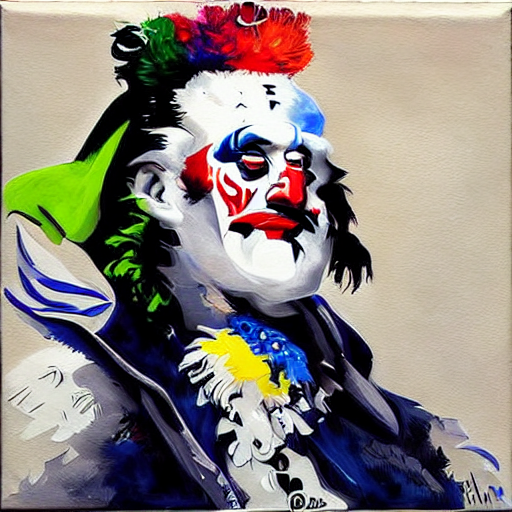

In [12]:
Image.fromarray(results[2])

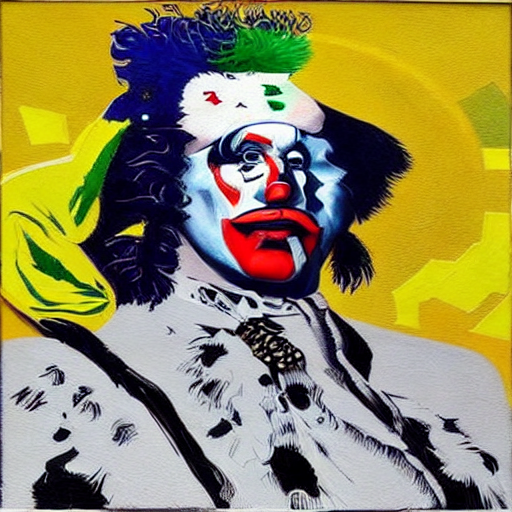

In [13]:
Image.fromarray(results[3])

In [4]:
block = gr.Blocks().queue()
with block:
    with gr.Row():
        gr.Markdown("## Control Stable Diffusion with Canny Edge Maps")
        #gr.Markdown("This _example_ was **drive** from <br/><b><h4>[https://github.com/svjack/ControlLoRA-Chinese](https://github.com/svjack/ControlLoRA-Chinese)</h4></b>\n")
    with gr.Row():
        with gr.Column():
            input_image = gr.Image(source='upload', type="numpy", value = "Protector_Cromwell_style.png")
            prompt = gr.Textbox(label="Prompt", value = "一个表情俏皮的小丑")
            run_button = gr.Button(label="Run")
            with gr.Accordion("Advanced options", open=False):
                num_samples = gr.Slider(label="Images", minimum=1, maximum=12, value=1, step=1)
                image_resolution = gr.Slider(label="Image Resolution", minimum=256, maximum=768, value=512, step=256)
                low_threshold = gr.Slider(label="Canny low threshold", minimum=1, maximum=255, value=100, step=1)
                high_threshold = gr.Slider(label="Canny high threshold", minimum=1, maximum=255, value=200, step=1)
                sample_steps = gr.Slider(label="Steps", minimum=1, maximum=100, value=20, step=1)
                scale = gr.Slider(label="Guidance Scale", minimum=0.1, maximum=30.0, value=9.0, step=0.1)
                seed = gr.Slider(label="Seed", minimum=-1, maximum=2147483647, step=1, randomize=True)
                eta = gr.Number(label="eta", value=0.0)
                a_prompt = gr.Textbox(label="Added Prompt", value='详细的模拟混合媒体拼贴画，帆布质地的当代艺术风格，朋克艺术，逼真主义，感性的身体，表现主义，极简主义。杰作，完美的组成，逼真的美丽的脸')
                n_prompt = gr.Textbox(label="Negative Prompt",
                                      value='低质量，模糊，混乱')
        with gr.Column():
            result_gallery = gr.Gallery(label='Output', show_label=False, elem_id="gallery").style(grid=2, height='auto')
    ips = [input_image, prompt, a_prompt, n_prompt, num_samples, image_resolution, sample_steps, scale, seed, eta, low_threshold, high_threshold]
    run_button.click(fn=process, inputs=ips, outputs=[result_gallery], show_progress = True)



/environment/miniconda3/lib/python3.7/site-packages/gradio/components.py:4424: UserWarning: The 'grid' parameter will be deprecated. Please use 'columns' instead.
  "The 'grid' parameter will be deprecated. Please use 'columns' instead.",


In [5]:
block.launch(server_name='172.16.54.41', share = True)

Running on local URL:  http://172.16.54.41:7860
Running on public URL: https://97fdcdc8e6a65f6138.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [11]:
###??run_button.click

Signature:     
run_button.click(
    fn: 'Callable | None',
    inputs: 'Component | List[Component] | Set[Component] | None' = None,
    outputs: 'Component | List[Component] | None' = None,
    api_name: 'str | None' = None,
    status_tracker: 'StatusTracker | None' = None,
    scroll_to_output: 'bool' = False,
    show_progress: 'bool | None' = None,
    queue: 'bool | None' = None,
    batch: 'bool' = False,
    max_batch_size: 'int' = 4,
    preprocess: 'bool' = True,
    postprocess: 'bool' = True,
    cancels: 'Dict[str, Any] | List[Dict[str, Any]] | None' = None,
    every: 'float | None' = None,
    _js: 'str | None' = None,
) -> 'Dependency'
Type:           EventListenerMethod
String form:    <gradio.events.EventListenerMethod object at 0x7f7993348c50>
File:           /environment/miniconda3/lib/python3.7/site-packages/gradio/events.py
Source:        
class EventListenerMethod:
    """
    Triggered on an event deployment.
    """

    def __init__(
        self,
        tr